In [61]:
from collections import Counter
import scipy.stats
import matplotlib.pyplot as plt
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus.reader.conll import ConllCorpusReader
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import sklearn_crfsuite
from sklearn_crfsuite import scorers, metrics
from operator import itemgetter
from random import seed
from nltk.stem import LancasterStemmer
import string

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rsury\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [62]:
conll_reader = ConllCorpusReader(root='./', fileids='.conll', columntypes=('words','pos','tree','chunk','ne','srl','ignore'))

In [63]:
def read_wnut(file):
    pos = [nltk.pos_tag(sentence) for sentence in conll_reader.sents(file)]
    label = list(conll_reader.tagged_sents(file))
    return [[(word,pos,label) for (word,pos),(word,label) in zip(pos, label)] for pos,label in zip(pos,label)]

Train_sents = read_wnut("./data/wnut17train.conll")

Dev_sents = read_wnut("./data/emerging.dev.conll")

Test_sents = read_wnut("./data/emerging.test.annotated")

In [64]:
Train_set_words_count = sum([len(word) for word in Train_sents])
Dev_set_words_count = sum([len(word) for word in Dev_sents])
Test_set_words_count = sum([len(word) for word in Test_sents])

In [65]:
print(f"Train_set has:\n {len(Train_sents):5} Sentences and {Train_set_words_count:5} Words")
print(f"Dev_set has:\n {len(Dev_sents):5} Sentences and {Dev_set_words_count:5} Words")
print(f"Test_set has:\n {len(Test_sents):5} Sentences and {Test_set_words_count:5} Words")

Train_set has:
  3394 Sentences and 62730 Words
Dev_set has:
  1009 Sentences and 15733 Words
Test_set has:
  1287 Sentences and 23394 Words


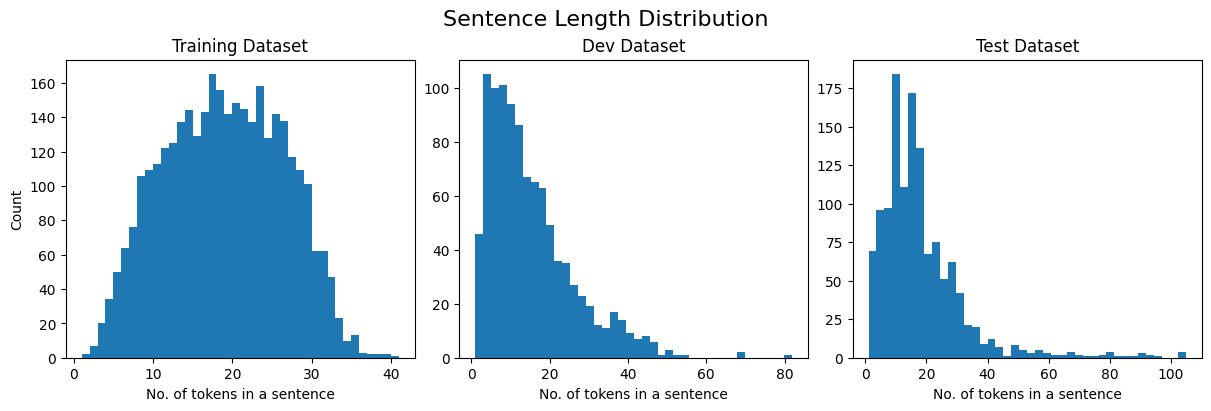

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 4))
fig.suptitle("Sentence Length Distribution", fontsize=16)
ax1.hist([len(word) for word in Train_sents], bins=40)
ax2.hist([len(word) for word in Dev_sents], bins=40)
ax3.hist([len(word) for word in Test_sents], bins=40)
ax1.set_title("Training Dataset");  ax2.set_title("Dev Dataset"); ax3.set_title("Test Dataset")
ax1.set_xlabel('No. of tokens in a sentence');ax2.set_xlabel('No. of tokens in a sentence');ax3.set_xlabel('No. of tokens in a sentence')
ax1.set_ylabel('Count')
plt.show()

In [67]:
def lbl_cnt(dataset):
    label_count, pos_count = {}, {}
    for sentence in dataset:
        for word, pos, label in sentence:
            if label not in label_count.keys():
                label_count[label] = 1
            else:
                label_count[label] += 1
            if pos not in pos_count.keys():
                pos_count[pos] = 1
            else:
                pos_count[pos] += 1
    pos_count = {k: v for k,v in sorted(pos_count.items(), key=itemgetter(0))}
    return label_count, pos_count

label_count_train, pos_count_train = lbl_cnt(Train_sents)
label_count_dev, pos_count_dev = lbl_cnt(Dev_sents)
label_count_test, pos_count_test = lbl_cnt(Test_sents)

In [68]:
label_count_train

{'O': 59570,
 'B-location': 548,
 'I-location': 245,
 'B-group': 264,
 'B-corporation': 221,
 'B-person': 660,
 'B-creative-work': 140,
 'B-product': 142,
 'I-person': 335,
 'I-creative-work': 206,
 'I-corporation': 46,
 'I-group': 150,
 'I-product': 203}

In [69]:
label_count_dev

{'O': 14483,
 'B-location': 74,
 'I-location': 33,
 'B-creative-work': 105,
 'I-creative-work': 133,
 'B-person': 470,
 'I-person': 117,
 'B-product': 114,
 'I-product': 94,
 'B-group': 39,
 'I-group': 25,
 'B-corporation': 34,
 'I-corporation': 12}

In [70]:
label_count_test

{'O': 21654,
 'B-location': 150,
 'I-location': 94,
 'B-group': 165,
 'I-group': 70,
 'B-person': 429,
 'I-person': 131,
 'B-creative-work': 142,
 'I-creative-work': 218,
 'B-corporation': 66,
 'B-product': 127,
 'I-corporation': 22,
 'I-product': 126}

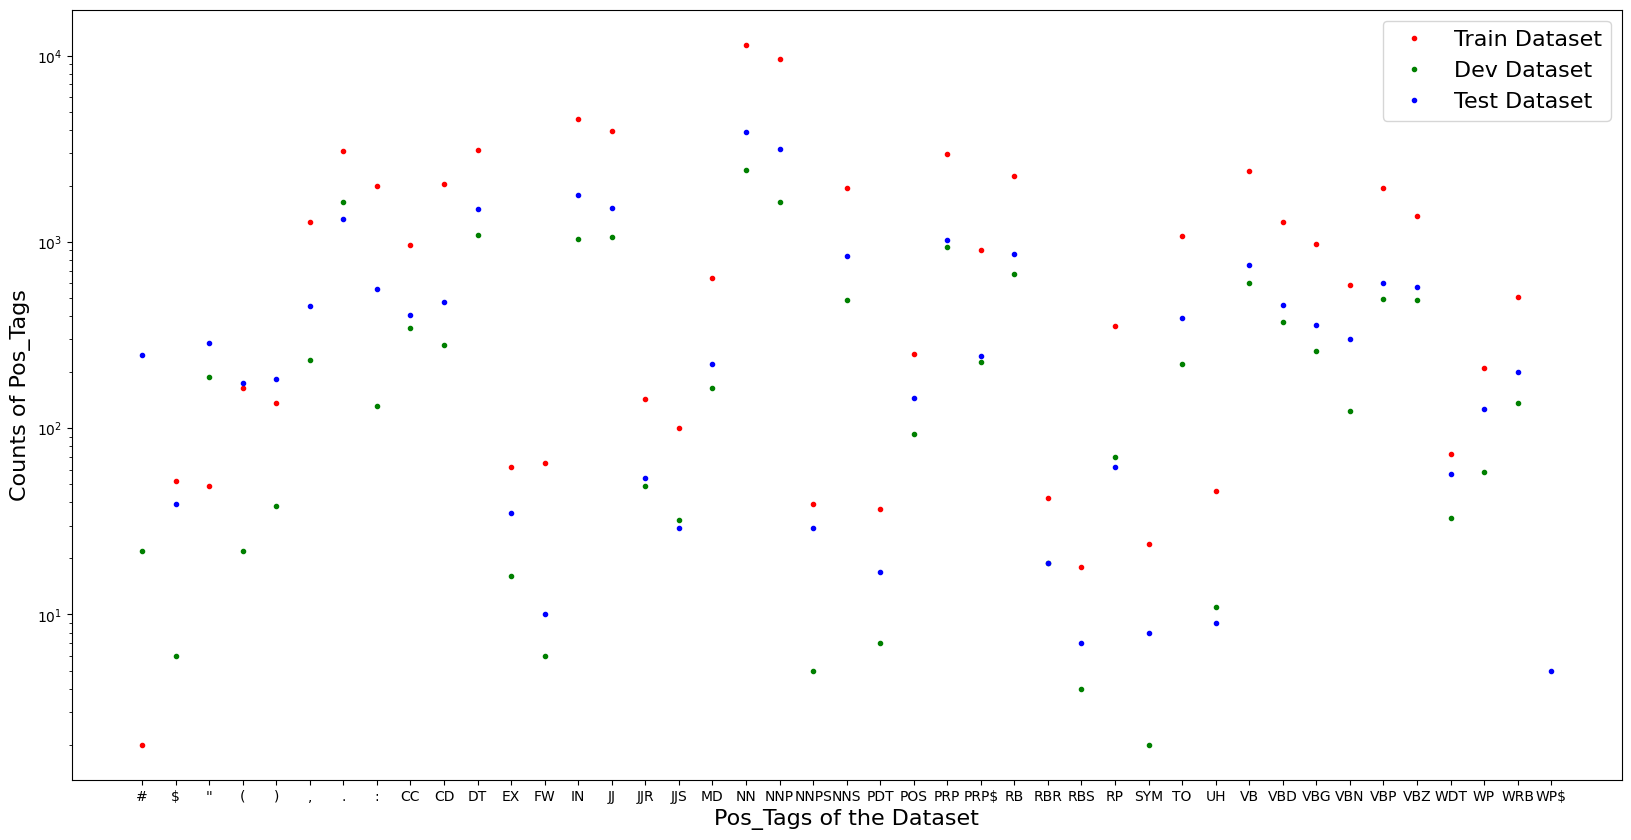

In [71]:
plt.figure(figsize= (20,10))
plt.semilogy([key for key, value in pos_count_train.items()], [value for key, value in pos_count_train.items()],  'r.')
plt.semilogy([key for key, value in pos_count_dev.items()], [value for key, value in pos_count_dev.items()],  'g.')
plt.semilogy([key for key, value in pos_count_test.items()], [value for key, value in pos_count_test.items()],  'b.')
plt.legend(['Train Dataset', 'Dev Dataset', 'Test Dataset'], fontsize=16)
plt.xlabel("Pos_Tags of the Dataset", fontsize=16)
plt.ylabel("Counts of Pos_Tags", fontsize=16)
plt.show()

In the above plot, Y-axis is in $log$ base 10 since, there is lot of difference between the avergage count and the max data.

**Label**

In [72]:
print(f"In Training set {label_count_train.__getitem__('O')/Train_set_words_count*100:.2f}% are labelled as O-Tag")
print(f"In Dev set {label_count_dev.__getitem__('O')/Dev_set_words_count*100:.2f}% are labelled as O-Tag")
print(f"In Test set {label_count_test.__getitem__('O')/Test_set_words_count*100:.2f}% are labelled as O-Tag")

In Training set 94.96% are labelled as O-Tag
In Dev set 92.05% are labelled as O-Tag
In Test set 92.56% are labelled as O-Tag


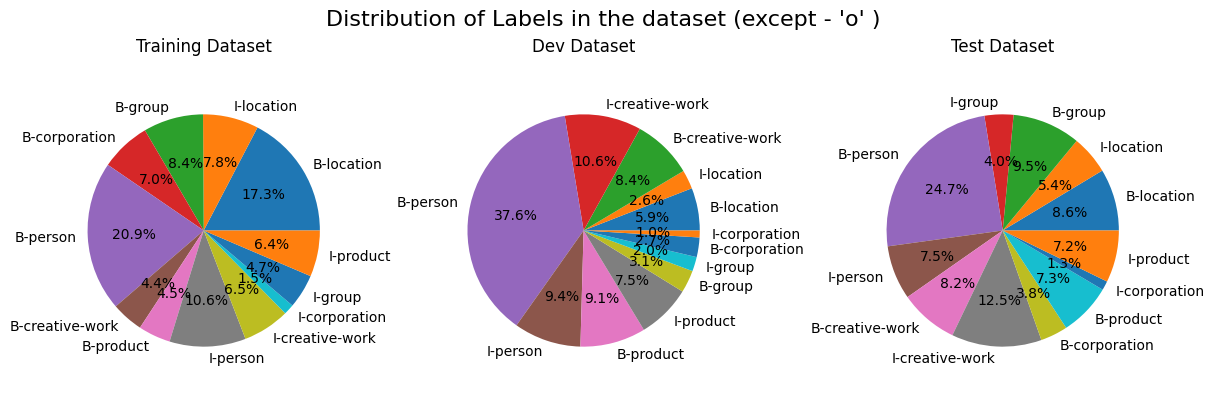

In [73]:
# Plotting the % of labels except 'O-tag', since majority of the data is O-tag.

dataset = ["Training Dataset", "Dev Dataset", "Test Dataset"]
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 4))
fig.suptitle("Distribution of Labels in the dataset (except - 'o' ) ", fontsize=16)
for i, (label_count, word_count) in enumerate(zip([label_count_train, label_count_dev, label_count_test], [Train_set_words_count, Dev_set_words_count, Test_set_words_count])):
        labels = [lbl for lbl,cnt in label_count.items() if lbl != 'O']
        sizes = [cnt/word_count*100 for lbl,cnt in label_count.items() if lbl != 'O']
        # fig1, ax1 = plt.subplots()
        ax[i].pie(sizes,  labels=labels, autopct='%1.1f%%', radius=100)
        ax[i].axis('equal')
        ax[i].set_title(dataset[i])
plt.show()

# Baseline Run on the dataset

In [74]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    # print(word, postag, i)

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }

    if i > 0:
        word1 = sent[i - 1][0]
        postag1 = sent[i - 1][1]
        # print(f" i > 0 : {word1} {postag1} {i}")
        features.update(
            {
                "-1:word.lower()": word1.lower(),
                "-1:word.istitle()": word1.istitle(),
                "-1:word.isupper()": word1.isupper(),
                "-1:postag": postag1,
                "-1:postag[:2]": postag1[:2],
            }
        )
    else:
        features["BOS"] = True

    if i < (len(sent) - 1):
        word1 = sent[i + 1][0]
        postag1 = sent[i + 1][1]
        # print(f" i < len : {word1} {postag1} {i}")
        features.update(
            {
                "+1:word.lower()": word1.lower(),
                "+1:word.istitle()": word1.istitle(),
                "+1:word.isupper()": word1.isupper(),
                "+1:postag": postag1,
                "+1:postag[:2]": postag1[:2],
            }
        )
    else:
        features["EOS"] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [75]:
X_train = [sent2features(s) for s in Train_sents]
y_train = [sent2labels(s) for s in Train_sents]

X_test = [sent2features(s) for s in Test_sents]
y_test = [sent2labels(s) for s in Test_sents]

Dev_X_train = [sent2features(s) for s in Dev_sents]
Dev_y_train = [sent2labels(s) for s in Dev_sents]

# Training - Baseline

In [76]:
crf_baseline = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf_baseline.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [77]:
labels = list(crf_baseline.classes_)
labels.remove('O')
print(labels)
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))

['B-location', 'I-location', 'B-group', 'B-corporation', 'B-person', 'B-creative-work', 'B-product', 'I-person', 'I-creative-work', 'I-corporation', 'I-group', 'I-product']


In [78]:
crf_baseline.score(X_test, y_test)

0.9286141745746773

In [79]:
y_pred = crf_baseline.predict(X_test)
print(f'Accuracy of Test dataset on CRF_Baseline : {crf_baseline.score(X_test, y_test):.3f}%')
print(f'Test set classification report: \n {metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3)}')

Accuracy of Test dataset on CRF_Baseline : 0.929%
Test set classification report: 
                  precision    recall  f1-score   support

  B-corporation      0.000     0.000     0.000        66
  I-corporation      0.000     0.000     0.000        22
B-creative-work      0.333     0.035     0.064       142
I-creative-work      0.296     0.037     0.065       218
        B-group      0.300     0.036     0.065       165
        I-group      0.357     0.071     0.119        70
     B-location      0.385     0.233     0.290       150
     I-location      0.231     0.064     0.100        94
       B-person      0.551     0.138     0.220       429
       I-person      0.547     0.221     0.315       131
      B-product      0.600     0.024     0.045       127
      I-product      0.375     0.048     0.085       126

      micro avg      0.430     0.093     0.153      1740
      macro avg      0.331     0.076     0.114      1740
   weighted avg      0.401     0.093     0.142      1740



Eventhough the CRF score is 92.86%, the model is not performing well on predicting the B and I Tags from the data.

# HyperParameter Optimization

In [92]:
seed(42)

crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs", max_iterations=100
)

params_space = {
    "c1": scipy.stats.expon(scale=0.5),
    "c2": scipy.stats.expon(scale=0.05),
    'all_possible_transitions': [True,False],
    # 'all_possible_states' : [False, True]
}

f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)

rs = RandomizedSearchCV(
    crf, params_space, cv=3, verbose=1, n_jobs=-1, n_iter=50, scoring=f1_scorer
)

# rs.fit(Dev_X_train, Dev_y_train)
rs.fit(X = X_train, y = y_train, X_dev = Dev_X_train, y_dev = Dev_y_train)
# rs.fit(X_train + Dev_X_train, y_train + Dev_y_train )
# y_pred = rs.predict(X_test)

metrics.flat_f1_score(y_test, y_pred, average="weighted", labels=labels) # 0.9041635368707299 # 0.9089425334899843

Fitting 3 folds for each of 50 candidates, totalling 150 fits


0.13567248328545295

Dark blue => 0.2836, dark red => 0.3968


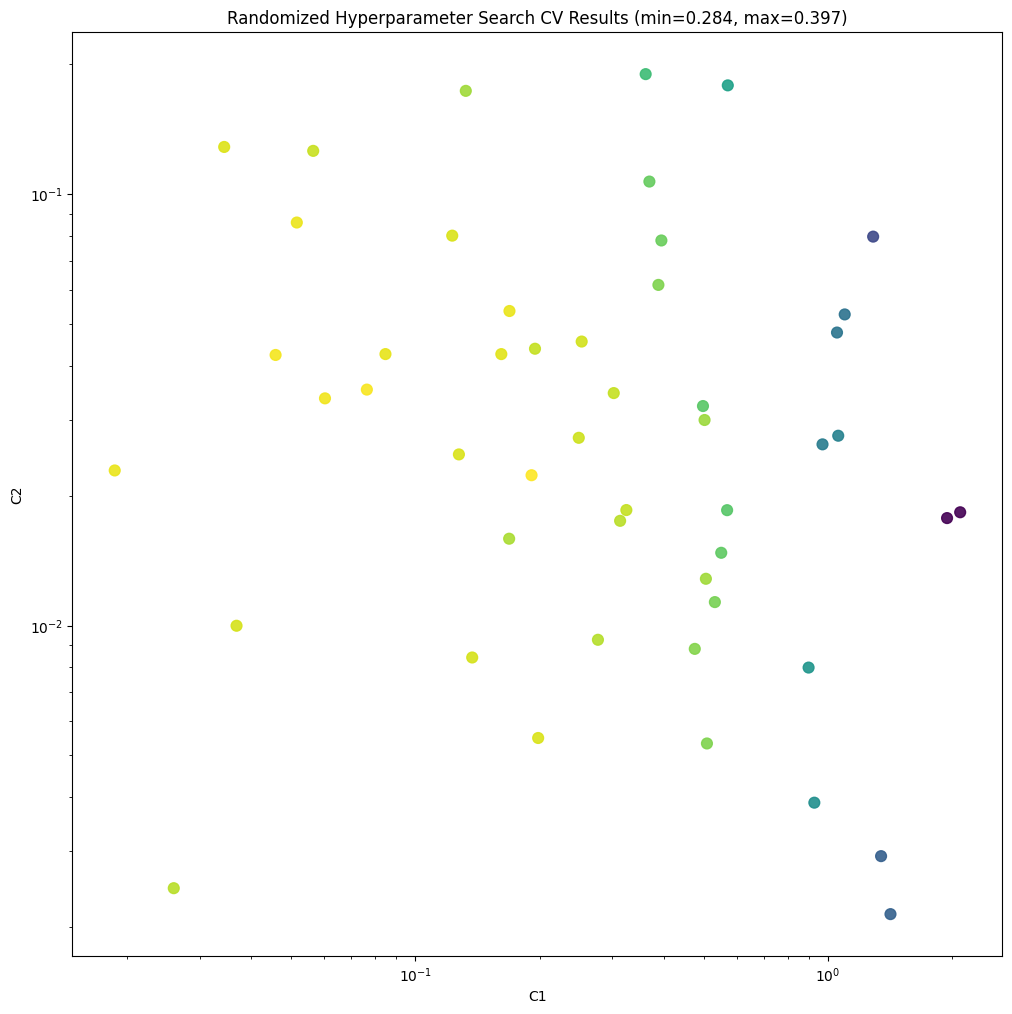

In [93]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9)

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [105]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)  # type: ignore
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

                 precision    recall  f1-score   support

  B-corporation      0.000     0.000     0.000        66
  I-corporation      0.000     0.000     0.000        22
B-creative-work      0.250     0.028     0.051       142
I-creative-work      0.310     0.041     0.073       218
        B-group      0.174     0.024     0.043       165
        I-group      0.267     0.057     0.094        70
     B-location      0.314     0.213     0.254       150
     I-location      0.290     0.096     0.144        94
       B-person      0.591     0.121     0.201       429
       I-person      0.500     0.176     0.260       131
      B-product      0.400     0.016     0.030       127
      I-product      0.179     0.040     0.065       126

      micro avg      0.374     0.083     0.136      1740
      macro avg      0.273     0.068     0.101      1740
   weighted avg      0.355     0.083     0.127      1740



In [95]:
print(f'Accuracy : {rs.best_estimator_.score(X_test, y_test)}')
print(f'best params: {rs.best_params_}')
print(f'best CV score: {rs.best_score_}')
print(f'model size:{rs.best_estimator_.size_ / 1000000:.2f}M')  

Accuracy : 0.9273317944772164
best params: {'all_possible_transitions': False, 'c1': 0.19119187184327427, 'c2': 0.0222948233534616}
best CV score: 0.39680451874032446
model size:0.62M


Again the accuarcy for 'lbfgs' model is good 92.2% (fitted against Dev set). but, still our model struggle to identify B and I Tags.

In [96]:
l2 = sklearn_crfsuite.CRF(algorithm='l2sgd', max_iterations=100)
params_space = {
                'c2': scipy.stats.expon(scale=0.05),
                'all_possible_transitions': [True,False],
                # 'all_possible_states' : [True,False],
               }
rs_l2 = RandomizedSearchCV(l2, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=make_scorer(metrics.flat_f1_score, average='weighted', labels=labels))
# rs_l2.fit(X_train, y_train)
# rs_l2.fit(Dev_X_train, Dev_y_train)
rs_l2.fit(X = X_train, y = y_train, X_dev = Dev_X_train, y_dev = Dev_y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=CRF(algorithm='l2sgd', max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'all_possible_transitions': [True,
                                                                     False],
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000026327DBE1D0>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-location', 'I-location', 'B-group', 'B-corporation', 'B-person', 'B-creative-work', 'B-product', 'I-person', 'I-creative-work', 'I-corporation', 'I-group', 'I-product']),
                   verbose=1)

In [97]:
print(f'Accuracy : {rs_l2.best_estimator_.score(X_test, y_test)}')
print(f'best params: {rs_l2.best_params_}')
print(f'best CV score: {rs_l2.best_score_}')
print(f'model size:{rs_l2.best_estimator_.size_ / 1000000:.2f}M')  

Accuracy : 0.9289133965974181
best params: {'all_possible_transitions': True, 'c2': 0.062475389194150494}
best CV score: 0.42864956268827703
model size:3.83M


In [98]:
crf_l2 = rs_l2.best_estimator_
y_pred = crf_l2.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=5))

                 precision    recall  f1-score   support

  B-corporation    0.33333   0.01515   0.02899        66
  I-corporation    0.50000   0.04545   0.08333        22
B-creative-work    0.33333   0.02113   0.03974       142
I-creative-work    0.55556   0.02294   0.04405       218
        B-group    0.21429   0.01818   0.03352       165
        I-group    0.28571   0.02857   0.05195        70
     B-location    0.32632   0.20667   0.25306       150
     I-location    0.41176   0.07447   0.12613        94
       B-person    0.59756   0.11422   0.19178       429
       I-person    0.66667   0.19847   0.30588       131
      B-product    0.66667   0.01575   0.03077       127
      I-product    0.33333   0.00794   0.01550       126

      micro avg    0.46290   0.07529   0.12951      1740
      macro avg    0.43538   0.06408   0.10039      1740
   weighted avg    0.46828   0.07529   0.11849      1740



For the Stochastic Gradient Descent with L2 Regularization 'l2sgd' the accuarcy is 92.31% (fitted against Dev set), we have a slight improvement on identifying the B-Tags.

# Model Learnings

In [99]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print(f"{label_from:15} --> {label_to:15} {weight}")

print("Top likely transitions:")
print_transitions(Counter(crf_l2.transition_features_).most_common(20))  # type: ignore

print("\nTop unlikely transitions:")
print_transitions(Counter(crf_l2.transition_features_).most_common()[-20:])  # type: ignore

Top likely transitions:
B-person        --> I-person        6.583251
B-creative-work --> I-creative-work 6.271652
I-creative-work --> I-creative-work 5.961103
B-location      --> I-location      5.831674
B-product       --> I-product       5.64944
I-product       --> I-product       5.607278
B-group         --> I-group         5.533829
I-group         --> I-group         5.386188
I-location      --> I-location      4.705935
B-corporation   --> I-corporation   4.418783
O               --> O               3.980539
I-person        --> I-person        3.862392
I-corporation   --> I-corporation   3.809919
O               --> B-person        2.982745
O               --> B-product       2.689934
O               --> B-group         2.554747
O               --> B-corporation   2.496444
O               --> B-location      2.091439
O               --> B-creative-work 1.99942
B-location      --> B-location      0.888868

Top unlikely transitions:
I-person        --> B-group         -0.812185
B-cor

In [100]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        # print("%0.6f %-8s %s" % (weight, label, attr))
        print(f"{weight:9} : {label:15} : {attr}")

print("Top positive:")
print_state_features(Counter(crf_l2.state_features_).most_common(30))  # type: ignore

print("\nTop negative:")
print_state_features(Counter(crf_l2.state_features_).most_common()[-30:])  # type: ignore

Top positive:
  8.26003 : B-corporation   : word.lower():twitter
 5.669261 : O               : bias
 5.123325 : B-product       : word.lower():iphone
 4.869207 : B-person        : word.lower():pope
  4.51118 : B-corporation   : word.lower():facebook
 3.962885 : B-corporation   : word.lower():walmart
 3.861712 : B-group         : -1:word.lower():vs
 3.718102 : B-location      : word.lower():jupiter
 3.618839 : O               : EOS
 3.584577 : B-group         : +1:word.lower():vs
  3.47667 : B-location      : -1:word.lower():at
 3.358367 : O               : BOS
 3.325541 : B-person        : word.lower():taylor
 3.234272 : B-person        : word.lower():beyonce
  3.19563 : B-person        : word.lower():justin
 3.133477 : B-location      : word.lower():aintree
 3.133477 : B-location      : -1:word.lower():bbt
 3.057092 : B-group         : word.lower():eagles
 3.014054 : O               : word[-3:]:day
 2.995506 : B-corporation   : BOS
  2.92014 : B-person        : word.lower():billy
 2.9

In [101]:
import eli5
eli5.show_weights(crf_l2, top=5)

From \ To,O,B-corporation,I-corporation,B-creative-work,I-creative-work,B-group,I-group,B-location,I-location,B-person,I-person,B-product,I-product
O,3.981,2.496,-2.21,1.999,-3.251,2.555,-2.725,2.091,-2.991,2.983,-2.777,2.69,-2.791
B-corporation,0.202,-0.519,4.419,-0.453,-0.594,-0.719,-0.621,0.647,-0.598,-0.857,-0.679,-0.532,-0.655
I-corporation,-0.508,-0.248,3.81,-0.198,-0.219,-0.282,-0.274,0.38,-0.311,-0.49,-0.299,-0.378,-0.316
B-creative-work,-0.953,-0.464,-0.439,-0.323,6.272,-0.458,-0.454,-0.628,-0.551,-0.642,-0.577,-0.333,-0.506
I-creative-work,-0.53,-0.427,-0.419,-0.725,5.961,-0.517,-0.46,-0.718,-0.52,0.321,-0.571,-0.342,-0.546
B-group,-0.16,-0.778,-0.623,0.834,-0.737,0.187,5.534,-1.005,-0.754,-0.038,-0.779,-0.702,-0.753
I-group,0.002,-0.308,-0.34,-0.298,-0.434,-0.98,5.386,-0.719,-0.517,-0.783,-0.483,-0.376,-0.472
B-location,0.524,-0.685,-0.745,-0.605,-0.73,-0.885,-0.881,0.889,5.832,-1.016,-1.013,-0.584,-0.81
I-location,-0.359,-0.588,-0.704,-0.488,-0.57,0.405,-0.72,0.454,4.706,-0.394,-0.788,-0.6,-0.749
B-person,0.197,-0.585,-0.675,0.713,-0.789,-0.766,-0.866,-1.04,-0.774,-0.131,6.583,-0.878,-0.769


In [102]:
eli5.show_weights(crf_l2, top=10, targets=['O', 'B-corporation', 'I-person'])

In [103]:
eli5.show_weights(crf_l2, top=5, feature_re='^word',
                  horizontal_layout=False, show=['targets'])